In [1]:
import pandas
import cellrank as cr
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt

In [2]:
adata = sc.read('data/processed_epithelial.h5ad')
latent_adata = sc.read('../../../../../../../media/spencer/Extra HDD/fits/latentvelo_C2.h5ad')

In [3]:
latent_adata.obs['cell_type'] = adata.obs.cell_type.values
latent_adata.obs['cell_type_num'] = adata.obs.cell_type_num.values
latent_adata.obs['GW'] = adata.obs.GW.values
latent_adata.obs['GD'] = adata.obs.GD.values
latent_adata.obs['sample_week'] = adata.obs.sample_week.values

In [4]:
scv.pp.neighbors(latent_adata, use_rep='X', n_neighbors=30)
scv.pp.neighbors(adata, n_pcs=30, n_neighbors=30)

computing neighbors
    finished (0:01:40) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


In [5]:
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
vk = cr.kernels.VelocityKernel(latent_adata, 
        vkey='spliced_velocity', xkey='spliced').compute_transition_matrix()
pk = cr.kernels.PseudotimeKernel(latent_adata, 
          time_key='latent_time').compute_transition_matrix(threshold_scheme='soft')

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/14915 [00:00<?, ?cell/s]

  0%|          | 0/14915 [00:00<?, ?cell/s]

  0%|          | 0/14915 [00:00<?, ?cell/s]

In [6]:
k = 0.8*ck + 0.2*vk

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
k.compute_transition_matrix()

(0.8 * ConnectivityKernel[n=14915, dnorm=True, key='connectivities'] + 0.2 * VelocityKernel[n=14915, model='deterministic', similarity='correlation', softmax_scale=4.34])

In [8]:
g = cr.estimators.GPCCA(k)

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/lib/python3/dist-packages/ipykernel/pylab/backend_inline.py:18: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display
/usr/lib/python3/dist-packages/ipykernel/pylab/backend_inline.py:164: DeprecationWarning: `configure_inline_support` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.configure_inline_support()`
  configure_inline_support(ip, backend)


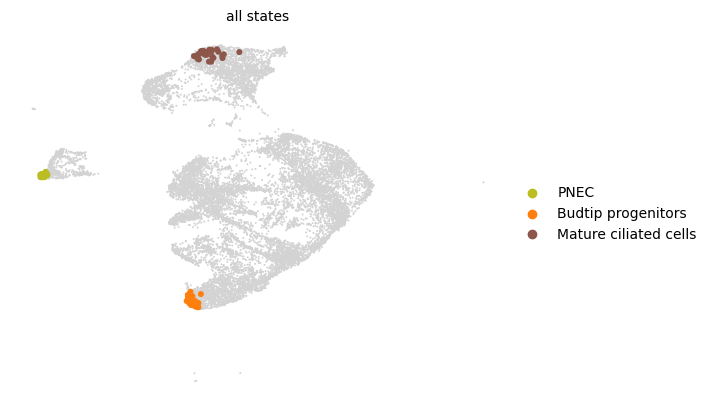

In [9]:
g.fit(cluster_key="cell_type", n_states=3)
g.plot_macrostates(which='all', discrete=True, legend_loc="right", s=75)

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


saving figure to file figures/epithelial_terminal_states.pdf


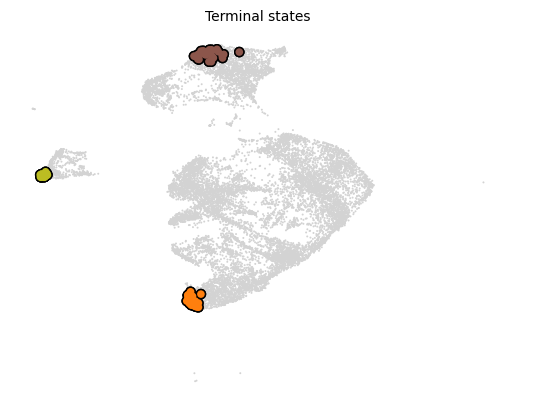

In [10]:
g.predict_terminal_states(allow_overlap=False)
g.plot_macrostates(which="terminal", legend_loc="right", s=100,
                  add_outline=[], outline_color=('black','black'),
                   outline_width=(0.00,0.2),
                  title='Terminal states',
                  save='figures/epithelial_terminal_states.pdf')

In [11]:
g.compute_fate_probabilities()

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/3 [00:00<?, ?/s]

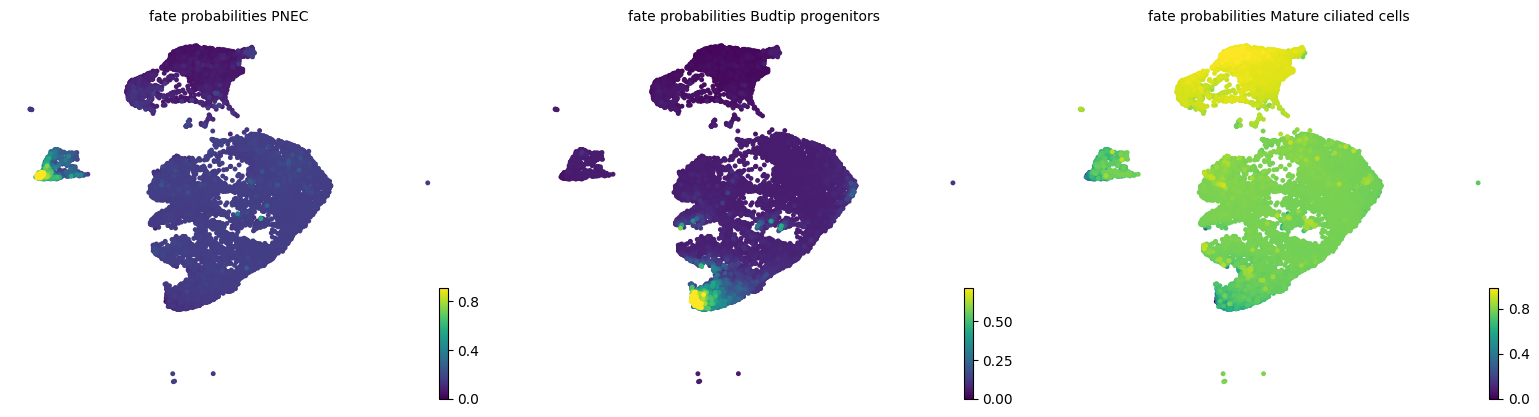

In [12]:
g.plot_fate_probabilities(same_plot=False, size=50)

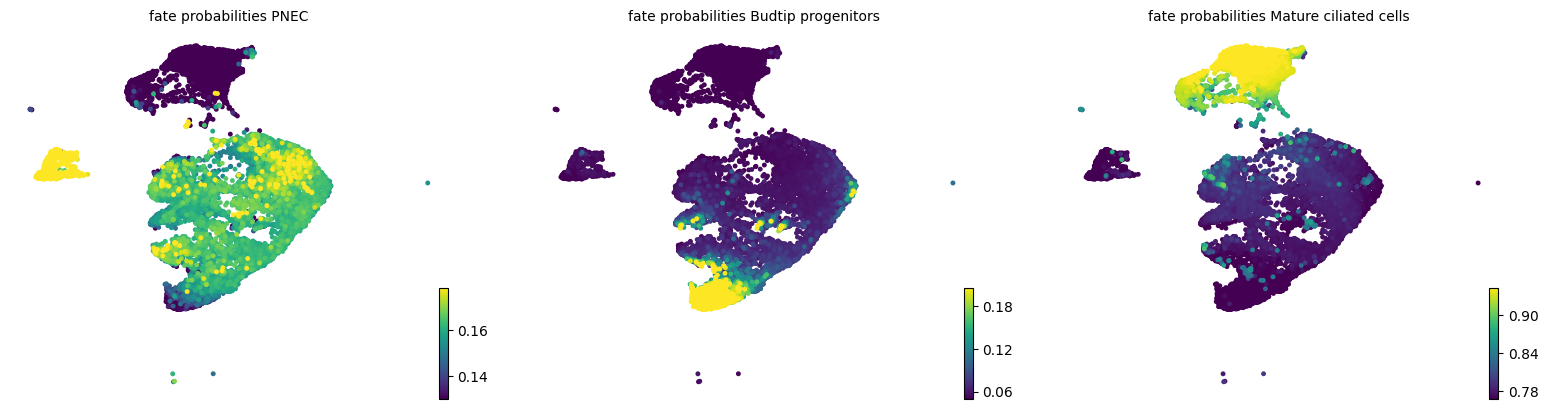

In [13]:
g.plot_fate_probabilities(same_plot=False, perc=[25,95], size=50)

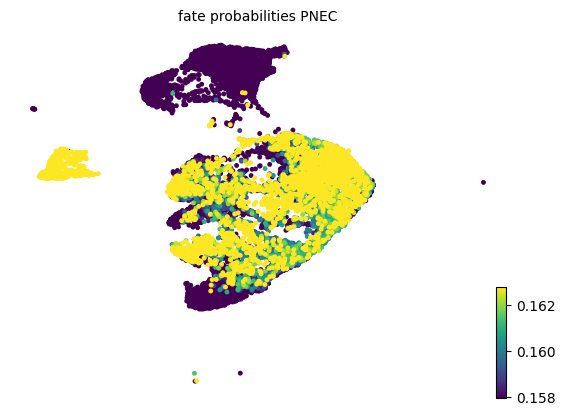

In [14]:
g.plot_fate_probabilities(same_plot=False, states=['PNEC'], perc=[50,80], size=50)

In [15]:
adata.obsm['lineages_fwd']

PNEC,Budtip progenitors,Mature ciliated cells
0.166594,0.064804,0.768602
0.163825,0.059640,0.776535
0.161872,0.065166,0.772962
0.163413,0.054852,0.781735
0.498275,0.035197,0.466528
0.161585,0.056220,0.782195
0.169176,0.066402,0.764422
0.161662,0.055493,0.782844
0.173572,0.053851,0.772577
0.163606,0.053415,0.782979


In [16]:
adata.obs['pnec_prob'] = adata.obsm['lineages_fwd']['PNEC'].X
adata.obs['ciliated_prob'] = adata.obsm['lineages_fwd']['Mature ciliated cells'].X
adata.obs['budtip_prob'] = adata.obsm['lineages_fwd']['Budtip progenitors'].X

In [17]:
from scipy.stats import spearmanr

rho_ciliated = spearmanr(adata[adata.obs.cell_type=='SCGB3A2+SFTPB+CFTR+ cells'].obs.GW,
               adata[adata.obs.cell_type=='SCGB3A2+SFTPB+CFTR+ cells'].obs.ciliated_prob)

rho_pnec = spearmanr(adata[adata.obs.cell_type=='SCGB3A2+SFTPB+CFTR+ cells'].obs.GW,
               adata[adata.obs.cell_type=='SCGB3A2+SFTPB+CFTR+ cells'].obs.pnec_prob)

print(rho_ciliated, rho_pnec)

SpearmanrResult(correlation=0.32233754957941885, pvalue=1.0884714144223147e-21) SpearmanrResult(correlation=-0.33754012521484994, pvalue=9.46055369322327e-24)


/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
adata.obs[['cell_type','ciliated_prob','pnec_prob', 'budtip_prob']]

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,cell_type,ciliated_prob,pnec_prob,budtip_prob
id,,,,
AAACCCAGTGACATCT-1_1,Proliferating progenitors,0.768602,0.166594,0.064804
AAACCCAGTTACACTG-1_1,Early AT2-like cells,0.776535,0.163825,0.059640
AAACCCATCCCATAGA-1_1,Early AT2-like cells,0.772962,0.161872,0.065166
AAAGGGCCAAGGTCAG-1_1,SOX2highCFTR+ cells,0.781735,0.163413,0.054852
AAAGGGCAGACAACTA-1_1,PNEC,0.466528,0.498275,0.035197
...,...,...,...,...
TTTCACAGTCGTCAGC-1_20,NKX2-1+SOX9+CFTR+ cells,0.779800,0.160832,0.059368
TTTACCAGTTTGTTGG-1_20,Basal cells,0.782417,0.159666,0.057918
TTGTTGTAGCGACTTT-1_20,NKX2-1+SOX9+CFTR+ cells,0.780690,0.160641,0.058669


In [22]:
adata.obs[['ciliated_prob','pnec_prob', 'budtip_prob', 'cell_type', 'GW']].to_csv('data/epithelial_terminal_fates_probs.csv')

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
adata.obs['Gestational week'] = ['GW'+x for x in adata.obs.GW.astype(str)]
adata.obs.GW = adata.obs.GW.astype(float)

latent_adata.obs['Gestational week'] = ['GW'+x for x in latent_adata.obs.GW.astype(str)]
latent_adata.obs['GW'] = latent_adata.obs.GW.astype(float)

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/spencer/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


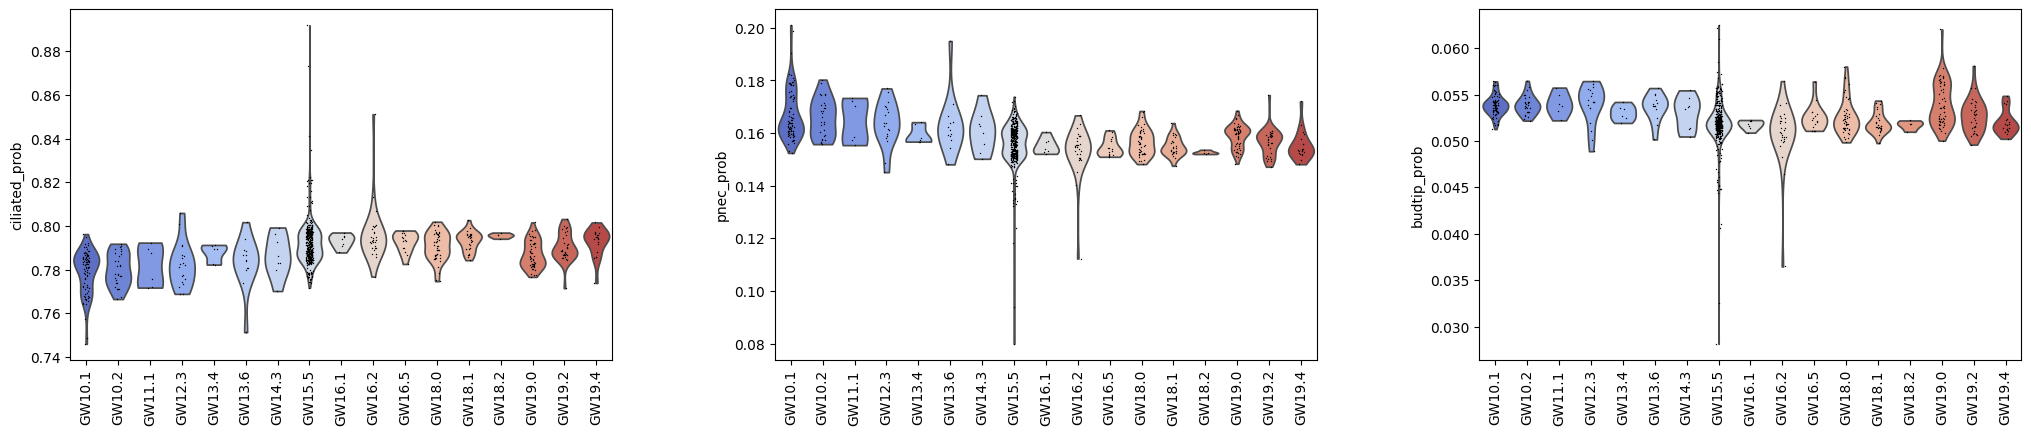

In [21]:
sc.pl.violin(adata[adata.obs.cell_type=='SCGB3A2+SFTPB+CFTR+ cells'], groupby='Gestational week',
            keys=['ciliated_prob','pnec_prob', 'budtip_prob'], palette='coolwarm',
            rotation=90)

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/spencer/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/spencer/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


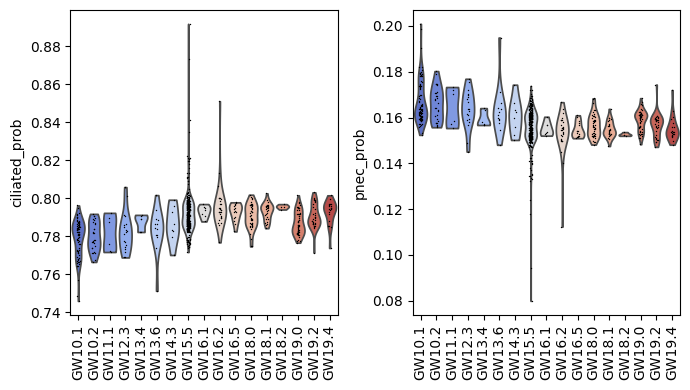

In [22]:
fig,ax=plt.subplots(1,2,figsize=(7,4))
ax=ax.flatten()
sc.pl.violin(adata[adata.obs.cell_type=='SCGB3A2+SFTPB+CFTR+ cells'], groupby='Gestational week',
            keys='ciliated_prob', palette='coolwarm',
            rotation=90, ax=ax[0], show=False)
sc.pl.violin(adata[adata.obs.cell_type=='SCGB3A2+SFTPB+CFTR+ cells'], groupby='Gestational week',
            keys='pnec_prob', palette='coolwarm',
            rotation=90, ax=ax[1], show=False)
#ax[0].set_ylim(0.74,0.84)
#ax[1].set_ylim(0.14,0.2)

#ax[0].set_ylim(0.,1)
#ax[1].set_ylim(0.,1)

plt.tight_layout()
plt.show()

In [27]:
adata.obs['latent_time']=latent_adata.obs.latent_time.values

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


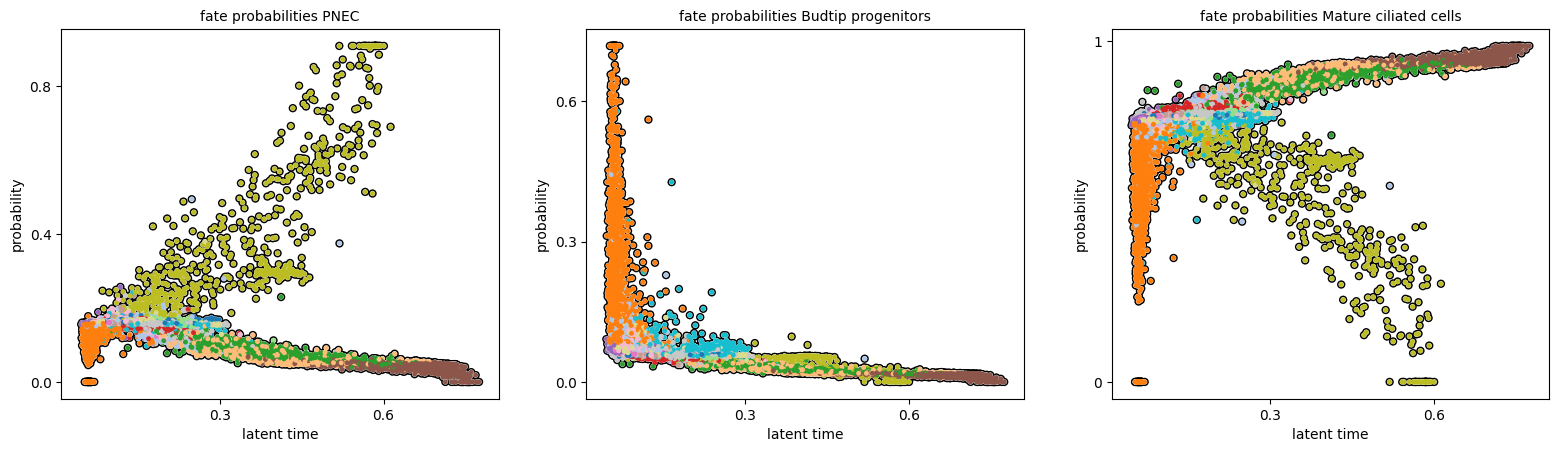

In [29]:
g.plot_fate_probabilities(same_plot=False, size=50, mode='time', time_key='latent_time',
                         color='cell_type', legend_loc='none',
                         add_outline=True)

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


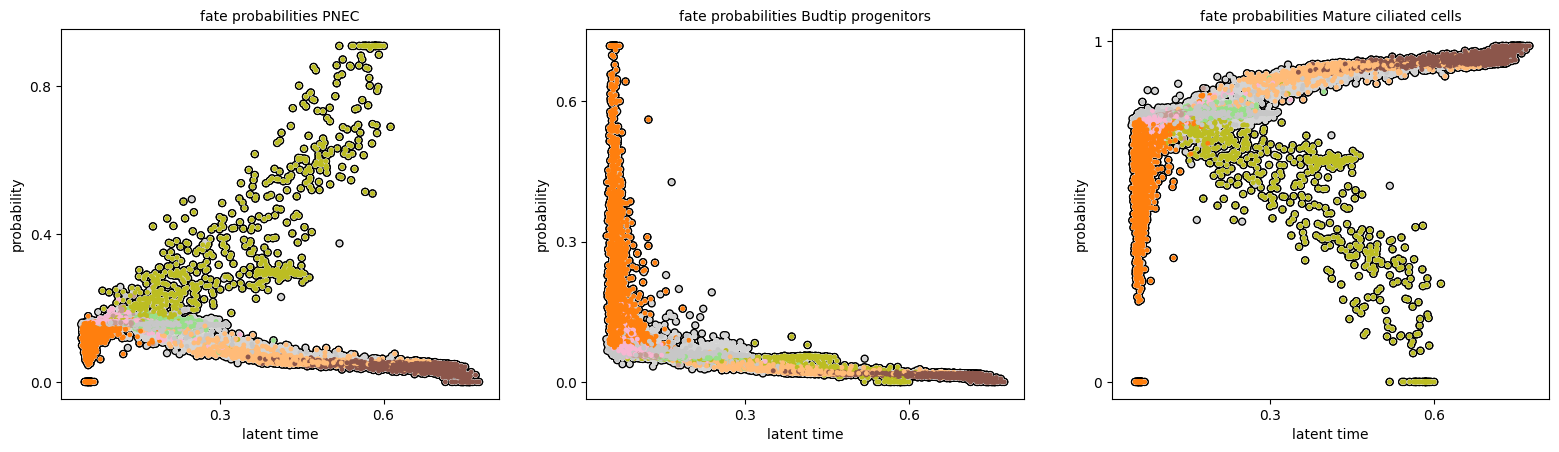

In [30]:
g.plot_fate_probabilities(same_plot=False, size=50, mode='time', time_key='latent_time',
                         color='cell_type', legend_loc='none',
                         groups=['SCGB3A2+SFTPB+CFTR+ cells', 'Stromal-like cells 1',
                                 'SCGB3A2+FOXJ1+ cells',
                                'Budtip progenitors', 'PNEC', 'Mature ciliated cells',
                                'SOX2highCFTR+ cells', 'SOX2lowCFTR+ cells'],
                         add_outline=True)